In this project I use random forest models to analyse hotel reviews. Main libraries used in this project include NLTK, Gensim and Scikit-learn. This will be done based on hotel reviews from Booking.com.

There are four parts in this project: text preprocessing, feature engineering, exploratory data analysis and model evaluation.

For each review, I want to predict if it is a good review or bad one. Review score is in the range of 2.5-10 (10 is the best). 

Keyword: text preprocessing, SentimentIntensityAnalyzer, doc2vec, tfidf, visualization, random forest

In [2]:
import zipfile
import pandas as pd
import numpy as np
import string
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve
from funcsigs import signature

In [3]:
zf = zipfile.ZipFile('515k-hotel-reviews-data-in-europe.zip')
data = pd.read_csv(zf.open('Hotel_Reviews.csv'))

In [5]:
data.head()
len(data)
#df.decribe()

515738

There are more than one hundred thousand records. It is time comsuming to using all of the data in later model. Therefore, I only take 10% of them as an example.

In [6]:
'''Reviews data is sampled in order to speed up computations.'''

data = data.sample(frac = 0.1, replace = False, random_state = 33)
data['review'] = data['Negative_Review'] + data['Positive_Review']
data['review'] = data['review'].apply(lambda x:x.replace('No Negative', '').replace('No Positive',''))
data["is_bad_review"] = data["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
df = data[["review", "is_bad_review"]]

Next I am going to preprocess text with NLTK library. The transformations contain:
1. lower the text
2. tokenize the text (split the text into words) and remove the punctuation
3. remove useless words that contain numbers
4. remove useless stop words like 'the', 'a' ,'this' etc.
5. remove empty token
6. Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
7. lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

In [8]:
def get_pos(pos):
    if pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('N'):
        return wordnet.NOUN
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def clean_text1(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(' ')]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop_words = stopwords.words('english')
    text = [word for word in text if word not in stop_words]
    text = [word for word in text if len(word) > 1]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_pos(t[1])) for t in pos_tags]
    text = ' '.join(text)
    return text

In [9]:
def clean_text2(text):
        """
        Clean text
        :param text: the string of text
        :return: text string after cleaning
        """
        # unit
        text = re.sub(r"(\d+)kgs ", lambda m: m.group(1) + ' kg ', text)        # e.g. 4kgs => 4 kg
        text = re.sub(r"(\d+)kg ", lambda m: m.group(1) + ' kg ', text)         # e.g. 4kg => 4 kg
        text = re.sub(r"(\d+)k ", lambda m: m.group(1) + '000 ', text)          # e.g. 4k => 4000
        text = re.sub(r"\$(\d+)", lambda m: m.group(1) + ' dollar ', text)
        text = re.sub(r"(\d+)\$", lambda m: m.group(1) + ' dollar ', text)

        # acronym
        text = re.sub(r"can\'t", "can not", text)
        text = re.sub(r"cannot", "can not ", text)
        text = re.sub(r"what\'s", "what is", text)
        text = re.sub(r"What\'s", "what is", text)
        text = re.sub(r"\'ve ", " have ", text)
        text = re.sub(r"n\'t", " not ", text)
        text = re.sub(r"i\'m", "i am ", text)
        text = re.sub(r"I\'m", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"c\+\+", "cplusplus", text)
        text = re.sub(r"c \+\+", "cplusplus", text)
        text = re.sub(r"c \+ \+", "cplusplus", text)
        text = re.sub(r"c#", "csharp", text)
        text = re.sub(r"f#", "fsharp", text)
        text = re.sub(r"g#", "gsharp", text)
        text = re.sub(r" e mail ", " email ", text)
        text = re.sub(r" e \- mail ", " email ", text)
        text = re.sub(r" e\-mail ", " email ", text)
        text = re.sub(r",000", '000', text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"wast", "was not", text)
        text = re.sub(r"weret", "were not", text)

        # spelling correction
        text = re.sub(r"ph\.d", "phd", text)
        text = re.sub(r"PhD", "phd", text)
        text = re.sub(r"pokemons", "pokemon", text)
        text = re.sub(r"pokémon", "pokemon", text)
        text = re.sub(r"pokemon go ", "pokemon-go ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r" 9 11 ", " 911 ", text)
        text = re.sub(r" j k ", " jk ", text)
        text = re.sub(r" fb ", " facebook ", text)
        text = re.sub(r"facebooks", " facebook ", text)
        text = re.sub(r"facebooking", " facebook ", text)
        text = re.sub(r"insidefacebook", "inside facebook", text)
        text = re.sub(r"donald trump", "trump", text)
        text = re.sub(r"the big bang", "big-bang", text)
        text = re.sub(r"the european union", "eu", text)
        text = re.sub(r" usa ", " america ", text)
        text = re.sub(r" us ", " america ", text)
        text = re.sub(r" u s ", " america ", text)
        text = re.sub(r" U\.S\. ", " america ", text)
        text = re.sub(r" US ", " america ", text)
        text = re.sub(r" American ", " america ", text)
        text = re.sub(r" America ", " america ", text)
        text = re.sub(r" quaro ", " quora ", text)
        text = re.sub(r" mbp ", " macbook-pro ", text)
        text = re.sub(r" mac ", " macbook ", text)
        text = re.sub(r"macbook pro", "macbook-pro", text)
        text = re.sub(r"macbook-pros", "macbook-pro", text)
        text = re.sub(r" 1 ", " one ", text)
        text = re.sub(r" 2 ", " two ", text)
        text = re.sub(r" 3 ", " three ", text)
        text = re.sub(r" 4 ", " four ", text)
        text = re.sub(r" 5 ", " five ", text)
        text = re.sub(r" 6 ", " six ", text)
        text = re.sub(r" 7 ", " seven ", text)
        text = re.sub(r" 8 ", " eight ", text)
        text = re.sub(r" 9 ", " nine ", text)
        text = re.sub(r"googling", " google ", text)
        text = re.sub(r"googled", " google ", text)
        text = re.sub(r"googleable", " google ", text)
        text = re.sub(r"googles", " google ", text)
        text = re.sub(r" rs(\d+)", lambda m: ' rs ' + m.group(1), text)
        text = re.sub(r"(\d+)rs", lambda m: ' rs ' + m.group(1), text)
        text = re.sub(r"the european union", " eu ", text)
        text = re.sub(r"dollars", " dollar ", text)

        # punctuation
        text = re.sub(r"\+", " + ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"-", " - ", text)
        text = re.sub(r"/", " / ", text)
        text = re.sub(r"\\", " \ ", text)
        text = re.sub(r"=", " = ", text)
        text = re.sub(r"\^", " ^ ", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r"\.", " . ", text)
        text = re.sub(r",", " , ", text)
        text = re.sub(r"\?", " ? ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"\"", " \" ", text)
        text = re.sub(r"&", " & ", text)
        text = re.sub(r"\|", " | ", text)
        text = re.sub(r";", " ; ", text)
        text = re.sub(r"\(", " ( ", text)
        text = re.sub(r"\)", " ( ", text)
        
        # symbol replacement
        text = re.sub(r"&", " and ", text)
        text = re.sub(r"\|", " or ", text)
        text = re.sub(r"=", " equal ", text)
        text = re.sub(r"\+", " plus ", text)
        text = re.sub(r"₹", " rs ", text)      # 测试！
        text = re.sub(r"\$", " dollar ", text)

        # remove extra space
        text = ' '.join(text.split())

        return text
df['reviews_c1'] = df['review'].apply(lambda x:clean_text1(x)).apply(lambda x:clean_text2(x))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


feature engineering
In this section I am going to generate some features based on text.
1. scores of sentiment. Vader, which is a part of the NLTK module designed for sentiment analysis, is ued. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:

a neutrality score
a positivity score
a negativity score
an overall score that summarizes the previous scores

2. vector representations. Each text will be transformed into numerical vectors using the word vectors (Doc2Vec).
3.  TF-IDF. I will add TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.

In [10]:
anal = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['reviews_c1'].apply(lambda x:anal.polarity_scores(x))
df = pd.concat([df.drop(['sentiment_scores'], axis = 1), df['sentiment_scores'].apply(pd.Series)], axis = 1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
doc = [TaggedDocument(doc, [i]) for i,doc in enumerate(df['reviews_c1'].apply(lambda x:x.split(' ')))]
m1 = Doc2Vec(doc, vector_size = 5, window = 2,  min_count=1, workers=4)
df2 = df['reviews_c1'].apply(lambda x:m1.infer_vector(x.split(' '))).apply(pd.Series)
df2.columns = ["doc2vec_vector_" + str(x) for x in df2.columns]
df = pd.concat([df,df2], axis = 1)

In [12]:
tfidf = TfidfVectorizer(min_df = 10)
tfidf_r1 = tfidf.fit_transform(df['reviews_c1']).toarray()
tfidf_r2 = pd.DataFrame(tfidf_r1, columns = tfidf.get_feature_names())
tfidf_r2.columns = ["word_" + str(x) for x in tfidf_r2.columns]
tfidf_r2.index = df.index
df = pd.concat([df, tfidf_r2], axis = 1)

In [24]:
df.shape

(51574, 3817)

Exploratory data analysis

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal r

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Serto Jerusalem Outline' (SyrCOMJerusalemOutline.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Serto Urhoy' (SyrCOMUrhoyBold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay-ThinItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Light.otf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luxi Mono' (luximri.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMoBd.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luxi Mono' (luximb.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.otf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kokonor' (Kokonor.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bitstream Vera Sans Mono' (VeraMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal black condensed>) = 10.725
DEBUG:matpl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Goha-Tibeb Zemen' (GohaTibebZemen.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Serto Mardin' (SyrCOMMardin.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luxi Serif' (luxirri.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sa

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Medium.ttc) normal normal medium normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal bold normal>) = 6.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular 

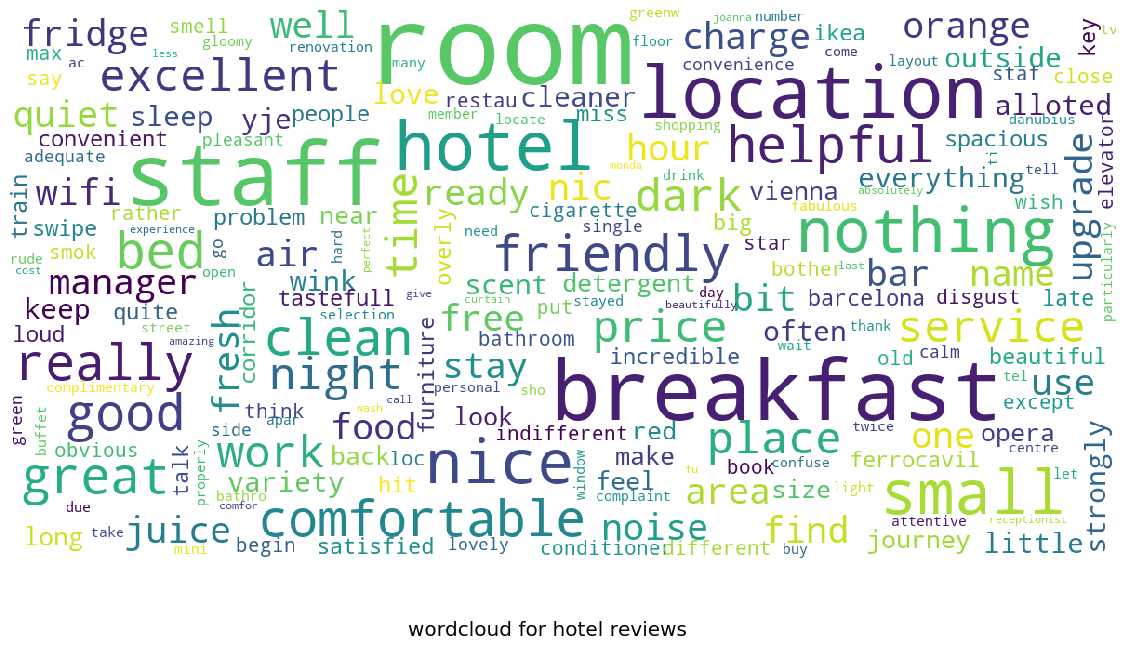

In [117]:
def show_wordcloud(data, title = 'wordcloud for hotel reviews'):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["reviews_c1"])


Most of the words are indeed related to the hotels: location, room, staff, breakfast, service etc. Some words are more related to the customer experience with the hotel stay: helpful, small, nice, clean, friendly etc.

In [14]:
# highest positive sentiment reviews (with more than 5 words)
df.sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
231290,Very relaxing,1.0
122205,What s not to like,1.0
429607,I liked it all Relaxed,1.0
40174,Beautiful,1.0
98031,All very good,1.0
399913,ok ok,1.0
339899,Excellent value,1.0
336902,Loved it,1.0
284909,Great,1.0
186882,It was very clean,1.0


In [15]:
# lowest negative sentiment reviews (with more than 5 words)
df.sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
226567,Fire alarm,1.0
432651,Couldn t fault it,1.0
271383,Very bad Very bad,1.0
63436,So dangerous,1.0
409738,not so bad,1.0
67798,dirty,1.0
224338,Couldn t fault it,1.0
20415,Noisy,1.0
395032,too noisy,1.0
481571,Noisy,1.0


In [16]:
df["is_bad_review"].value_counts(normalize = True)

0    0.956296
1    0.043704
Name: is_bad_review, dtype: float64

In [17]:
text_col = ['is_bad_review', 'review', 'reviews_c1']
feature = [c for c in df.columns if c not in text_col]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df[feature], df["is_bad_review"], test_size = 0.20, random_state = 42)

In [29]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances = pd.DataFrame({"feature": feature, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances.head(20)

,feature,importance
3,compound,0.030753
4,doc2vec_vector_0,0.021998
6,doc2vec_vector_2,0.020671
2,pos,0.020579
8,doc2vec_vector_4,0.019989
5,doc2vec_vector_1,0.019340
7,doc2vec_vector_3,0.018102
0,neg,0.017390
1,neu,0.014591
2852,word_room,0.011026


Some most important features are from Vader sentiment analysis. The vector representations of the texts also have a lot of importance in model. For the rest, some features calculated from the tfidf method also are important.

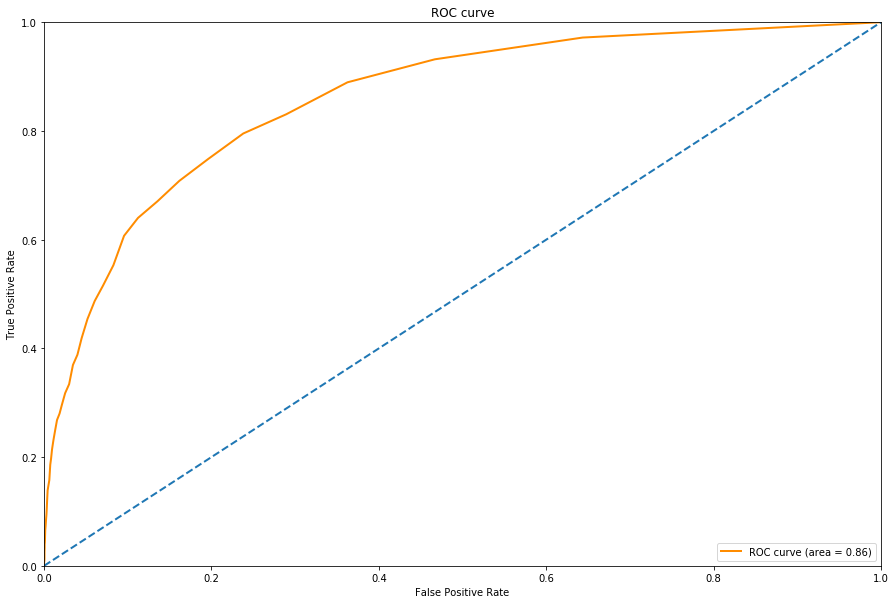

In [30]:
'''evaluate model'''

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

The ROC (Receiver Operating Characteristic) curve is usually a good graph to summarize the quality of rf classifier (imbalanced data). The higher the curve is above the diagonal baseline, the better the predictions. Although the AUC ROC (Area Under the Curve ROC) is good, here the ROC curve alone is not enough to assess the quality of rf model.

FPR = FP/P. In this data set, there are quite a lot positive reviews. Even with some false positive FPR will stay low. As far as increasing true positive rate, the AUC ROC metric will artificially increase.

PR curve is used to further check model performance.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.29')

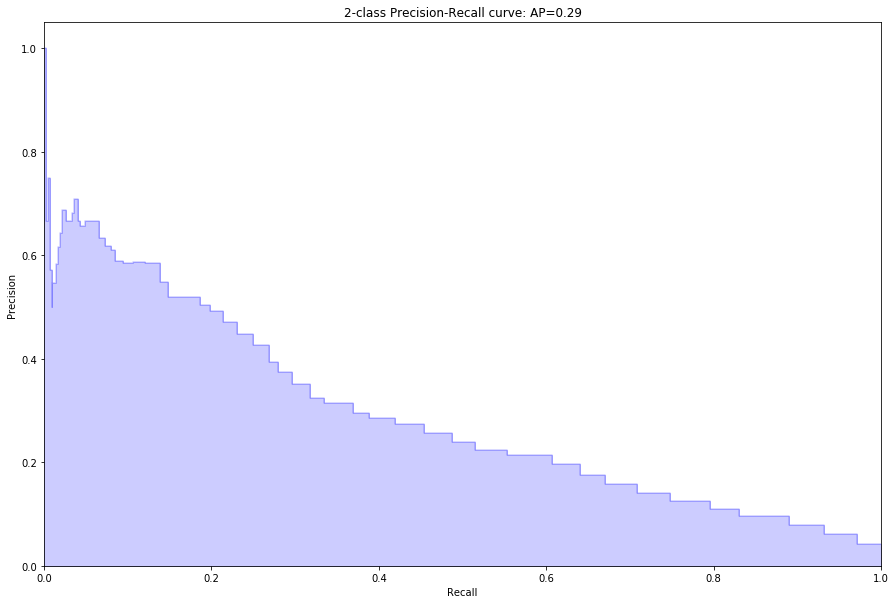

In [31]:
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


In order to know if one model performs better than another classifier, we can simply use the AP metric. To assess the quality of one model, we can compare it to a simple decision baseline. Let's take a random classifier as a baseline here that would predict half of the time 1 and half of the time 0 for the label.

Such a classifier would have a precision of 4.3%, which corresponds to the proportion of positive observations. For every recall value the precision would stay the same, and this would lead us to an AP of 0.043. The AP of our model is approximately 0.29, which is almost 7 times higher than the AP of the random method. This means that this model has a good predictive power.

Reference: Jonathan Oheix: https://www.kaggle.com/jonathanoheix/sentiment-analysis-with-hotel-reviews/?source=post_page-----d8b36134dc7e----------------------